<h1>📚Import Library Yang Dibutuhkan</h1>

In [66]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score
)
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve
)
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import (
    IterativeImputer,
    KNNImputer
)
from sklearn.preprocessing import (
    OrdinalEncoder,
    LabelEncoder
)
from sklearn.utils.class_weight import (
    compute_class_weight,
    compute_sample_weight
)

# Constants
RANDOM_STATE = 42
LABEL = 'coppaRisk'


<h1>📋Load Dataframe Yang Dibutuhkan</h1>
<ul> <li> <strong>train</strong> <ul> <li>Dibaca dari file <code>train.csv</code>.</li> <li>Berisi data latih (training data) yang digunakan untuk melatih model machine learning.</li> </ul> </li> <li> <strong>test</strong> <ul> <li>Dibaca dari file <code>test.csv</code>.</li> <li>Berisi data uji (testing data) tanpa label target.</li> <li>Kolom <code>'ID'</code> dihapus karena kemungkinan tidak relevan untuk prediksi.</li> </ul> </li> <li> <strong>target</strong> <ul> <li>Dibaca dari file <code>target.csv</code>.</li> <li>Berisi label target untuk data <code>train</code>.</li> <li>Kolom yang dipakai: <code>'coppaRisk'</code>, disimpan ke dalam variabel <code>y</code>.</li> </ul> </li> <li> <strong>submission_sample</strong> <ul> <li>Dibaca dari file <code>submission_format.csv</code>.</li> <li>Format yang digunakan untuk mengatur output prediksi sebelum disubmit ke Kaggle.</li> </ul> </li> <li> <strong>y</strong> <ul> <li>Label target dari <code>target</code> DataFrame, yaitu kolom <code>'coppaRisk'</code>.</li> <li>Digunakan sebagai nilai yang akan diprediksi oleh model.</li> </ul> </li> <li> <strong>X</strong> <ul> <li>Salinan dari <code>train</code>.</li> <li>Biasanya dipakai untuk eksplorasi fitur atau preprocessing tanpa mengubah data asli.</li> </ul> </li> </ul>

In [67]:
# Load Data
train = pd.read_csv("/kaggle/input/finditdac/dataset/train.csv")
test = pd.read_csv("/kaggle/input/finditdac/dataset/test.csv")
test = test.drop(columns=['ID'])
target = pd.read_csv("/kaggle/input/finditdac/dataset/target.csv")
submission_sample = pd.read_csv("/kaggle/input/finditdac/dataset/submission_format.csv")
y = target['coppaRisk']
X = train.copy()

In [68]:
X.head()

,developerCountry,countryCode,userRatingCount,primaryGenreName,downloads,deviceType,hasPrivacyLink,hasTermsOfServiceLink,hasTermsOfServiceLinkRating,isCorporateEmailScore,adSpent,appAge,averageUserRating,appContentBrandSafetyRating,appDescriptionBrandSafetyRating,mfaRating
0,NORWAY,RO,127731,Sports,NaN,smartphone,True,True,low,99.0,14.017220,160.400000,4.0,medium,low,low
1,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,0,Medical,50 - 100,GLOBAL,True,NaN,NaN,99.0,NaN,17.500000,0.0,NaN,low,low
2,UNITED ARAB EMIRATES,CZ,51143,Games,50000000 - 100000000,GLOBAL,True,True,low,0.0,31.883163,30.766667,4.0,NaN,low,low
3,GERMANY,GLOBAL,1074,Games,NaN,GLOBAL,True,NaN,NaN,99.0,NaN,71.533333,4.0,NaN,low,low
4,CANNOT IDENTIFY COUNTRY,GLOBAL,17,Tools,1000 - 5000,GLOBAL,True,NaN,NaN,99.0,NaN,52.400000,4.0,NaN,low,low


In [69]:
test.head()

,developerCountry,countryCode,userRatingCount,primaryGenreName,downloads,deviceType,hasPrivacyLink,hasTermsOfServiceLink,hasTermsOfServiceLinkRating,isCorporateEmailScore,adSpent,appAge,averageUserRating,appContentBrandSafetyRating,appDescriptionBrandSafetyRating,mfaRating
0,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,2,Medical,NaN,GLOBAL,True,NaN,NaN,NaN,NaN,81.600000,5.0,NaN,low,low
1,ICELAND,EMEA,0,Games,5000 - 10000,GLOBAL,True,True,low,0.0,0.027742,24.700000,0.0,NaN,low,low
2,UNITED STATES,RU,13059,Games,NaN,smartphone,True,False,high,99.0,9.249056,40.300000,4.0,NaN,low,low
3,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,0,Games,NaN,GLOBAL,True,False,high,NaN,NaN,39.233333,0.0,NaN,medium,low
4,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,0,Shopping,NaN,GLOBAL,NaN,NaN,NaN,NaN,NaN,65.533333,0.0,NaN,low,low


# Data Preproccessing

<h2>Replace Missing value with nan</h2>
<ol>
    <li><strong> Kita bisa mengganti value yang tidak bernilai dengan nan</strong></li>
</ol>

In [70]:
X['developerCountry'] = X['developerCountry'].replace({
    "ADDRESS NOT LISTED IN PLAYSTORE": np.nan,
    "CANNOT IDENTIFY COUNTRY": np.nan
})

test['developerCountry'] = test['developerCountry'].replace({
    "ADDRESS NOT LISTED IN PLAYSTORE": np.nan,
    "CANNOT IDENTIFY COUNTRY": np.nan
})

<h1>🔎EDA(Explaratory Data Analysis)</h1>
<ul> <li> <strong>1. Melihat struktur data</strong> <ul> <li>Cek bentuk data: <code>df.shape</code></li> <li>Lihat beberapa baris pertama: <code>df.head()</code></li> <li>Periksa tipe data: <code>df.dtypes</code></li> </ul> </li> <li> <strong>2. Memeriksa missing values</strong> <ul> <li>Cari jumlah nilai hilang: <code>df.isnull().sum()</code></li> <li>Visualisasi missing values (misalnya pakai <code>sns.heatmap()</code>)</li> </ul> </li> <li> <strong>3. Statistik deskriptif</strong> <ul> <li>Gunakan <code>df.describe()</code> untuk melihat mean, std, min, max, dll.</li> <li><code>value_counts()</code> untuk data kategorikal.</li> </ul> </li> <li> <strong>4. Visualisasi distribusi fitur</strong> <ul> <li>Histogram atau KDE plot: <code>sns.histplot()</code>, <code>sns.kdeplot()</code></li> <li>Barplot untuk fitur kategorikal: <code>sns.countplot()</code></li> </ul> </li> <li> <strong>5. Analisis hubungan antar fitur</strong> <ul> <li>Hitung korelasi antar fitur numerik: <code>df.corr()</code></li> <li>Visualisasi dengan heatmap: <code>sns.heatmap()</code></li> </ul> </li> <li> <strong>6. Analisis hubungan fitur dengan target</strong> <ul> <li>Boxplot: <code>sns.boxplot(x=target, y=feature)</code></li> <li><code>groupby()</code> + <code>mean()</code> untuk analisis ringkasan</li> </ul> </li> <li> <strong>7. Outlier detection</strong> <ul> <li>Gunakan boxplot untuk mendeteksi outlier</li> <li>Pakai IQR (Interquartile Range) untuk deteksi manual</li> </ul> </li> </ul>

<h2>Statistika Deskriptif</h2>

In [71]:
X.describe()#ini hanya dilakukan pada numerik value

,userRatingCount,isCorporateEmailScore,adSpent,appAge,averageUserRating
count,7.000000e+03,5872.000000,1.321000e+03,6950.000000,5768.000000
mean,3.256274e+04,45.740293,3.977563e+03,57.093060,2.482490
std,5.501431e+05,49.361215,9.219919e+04,37.169895,1.905712
min,0.000000e+00,0.000000,7.038525e-03,0.533333,0.000000
25%,0.000000e+00,0.000000,1.086920e+00,27.533333,0.000000
50%,1.000000e+00,0.000000,7.945580e+00,52.866667,3.000000
75%,8.800000e+01,99.000000,4.908375e+01,80.000000,4.000000
max,3.854334e+07,99.000000,3.143906e+06,196.466667,5.000000


In [72]:
test.describe()#ini hanya dilakukan pada numerik value

,userRatingCount,isCorporateEmailScore,adSpent,appAge,averageUserRating
count,3.000000e+03,2560.000000,574.000000,2983.000000,2486.000000
mean,3.576905e+04,46.444922,286.612276,56.044396,2.490748
std,4.455556e+05,49.415285,1890.997697,36.417410,1.896230
min,0.000000e+00,0.000000,0.007450,-1.200000,0.000000
25%,0.000000e+00,0.000000,1.121507,26.933333,0.000000
50%,1.000000e+00,0.000000,7.186537,51.933333,3.000000
75%,8.250000e+01,99.000000,44.878463,77.750000,4.000000
max,1.319941e+07,99.000000,37542.779693,194.466667,5.000000


<h4>Temuannya adalah rata rata rating pengguna <strong>berada pada 1-5</strong> dan isi corporate email score <strong>hanya 0 dan 99</strong></h4>

In [73]:
set(train['averageUserRating'].unique())

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan}

In [74]:
set(test['averageUserRating'].unique())

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan}

In [75]:
set(train['isCorporateEmailScore'].unique())

{0.0, 99.0, nan}

In [76]:
set(test['isCorporateEmailScore'].unique())

{0.0, 99.0, nan}

<h4>Menunjukkan bahwa fitur lebih baik berada pada <strong>Kategorikal</strong></h4>

<h3>Temuan bahwa ada satu numerik value 'appAge' yaitu dibawah 0</h3>

In [77]:
test['appAge'].iloc[982]=test['appAge'].iloc[982]*-1

<h3>📖Ringkasan Statistik Deskriptif pada Data Train</h3>
<ul>
    <li>Kami menemukan bahwa kolom Corporate Email Score adalah kolom kategorikal karena hanya memiliki nilai unik 0 dan 99, bukan rentang dari 0 hingga 99.</li>
    <li>Kami menemukan bahwa kolom averageUserRating memiliki nilai unik terbatas dan hanya terdiri dari 5 item yang menyusun kolom tersebut.</li>
    <li>Kami menemukan bahwa fitur lainnya dapat digunakan untuk <strong>regresi atau berbasis klastering (Clustering Based)</strong>.</li>
</ul>

<h2>Check nilai Kosong pada dataframe</h2>


<h3>Ini pada kolom numerik,Bagaimana dengan kolom kategorikal?</h3>

In [78]:
missing_value_numeric = train.select_dtypes(include=['number']).isnull().sum().sort_values(ascending=False)
missing_percentage_numeric = (missing_value_numeric / len(train)) * 100
missing_analysis=pd.DataFrame({"Missing Values": missing_value_numeric, "Percentage": missing_percentage_numeric})
missing_analysis

,Missing Values,Percentage
adSpent,5679,81.128571
averageUserRating,1232,17.600000
isCorporateEmailScore,1128,16.114286
appAge,50,0.714286
userRatingCount,0,0.000000


In [79]:
missing_value_numeric = test.select_dtypes(include=['number']).isnull().sum().sort_values(ascending=False)
missing_percentage_numeric = (missing_value_numeric / len(test)) * 100
missing_analysis=pd.DataFrame({"Missing Values": missing_value_numeric, "Percentage": missing_percentage_numeric})
missing_analysis

,Missing Values,Percentage
adSpent,2426,80.866667
averageUserRating,514,17.133333
isCorporateEmailScore,440,14.666667
appAge,17,0.566667
userRatingCount,0,0.000000


<h3>Kolom kategorikal</h3>

In [80]:
missing_value_numeric = train.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
missing_percentage_numeric = (missing_value_numeric / len(train)) * 100
missing_analysis=pd.DataFrame({"Missing Values": missing_value_numeric, "Percentage": missing_percentage_numeric})
missing_analysis

,Missing Values,Percentage
appContentBrandSafetyRating,6162,88.028571
hasTermsOfServiceLink,4635,66.214286
hasTermsOfServiceLinkRating,4635,66.214286
downloads,2149,30.700000
hasPrivacyLink,750,10.714286
countryCode,64,0.914286
developerCountry,0,0.000000
primaryGenreName,0,0.000000
deviceType,0,0.000000
appDescriptionBrandSafetyRating,0,0.000000


In [81]:
missing_value_numeric = test.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
missing_percentage_numeric = (missing_value_numeric / len(test)) * 100
missing_analysis=pd.DataFrame({"Missing Values": missing_value_numeric, "Percentage": missing_percentage_numeric})
missing_analysis

,Missing Values,Percentage
appContentBrandSafetyRating,2671,89.033333
developerCountry,2152,71.733333
hasTermsOfServiceLink,1961,65.366667
hasTermsOfServiceLinkRating,1961,65.366667
downloads,881,29.366667
hasPrivacyLink,316,10.533333
countryCode,29,0.966667
primaryGenreName,0,0.000000
deviceType,0,0.000000
appDescriptionBrandSafetyRating,0,0.000000


<h3>Summary Missing Value</h3>
<ul>
    <li>banyak kolom yang dapat dihapus karena presentasi melebihi 50% data,namun hal itu bisa membuat kehilangan informasi</li>
    <li>Kami memutuskan melakukan inputasi</li>
</ul>

<h2>📊Plot bar pada kategorikal Value</h2>

In [82]:
categorical_cols = ['developerCountry', 'countryCode', 'primaryGenreName', 'deviceType', 
                    'appDescriptionBrandSafetyRating', 'mfaRating', 'hasTermsOfServiceLinkRating', 
                    'downloads', 'appContentBrandSafetyRating','averageUserRating','hasTermsOfServiceLink']
boolean_cols = ['hasPrivacyLink', 'isCorporateEmailScore']
numeric_cols = ['userRatingCount', 'appAge', 'adSpent']

# Gabungkan semua kolom
all_cols = numeric_cols + boolean_cols + categorical_cols

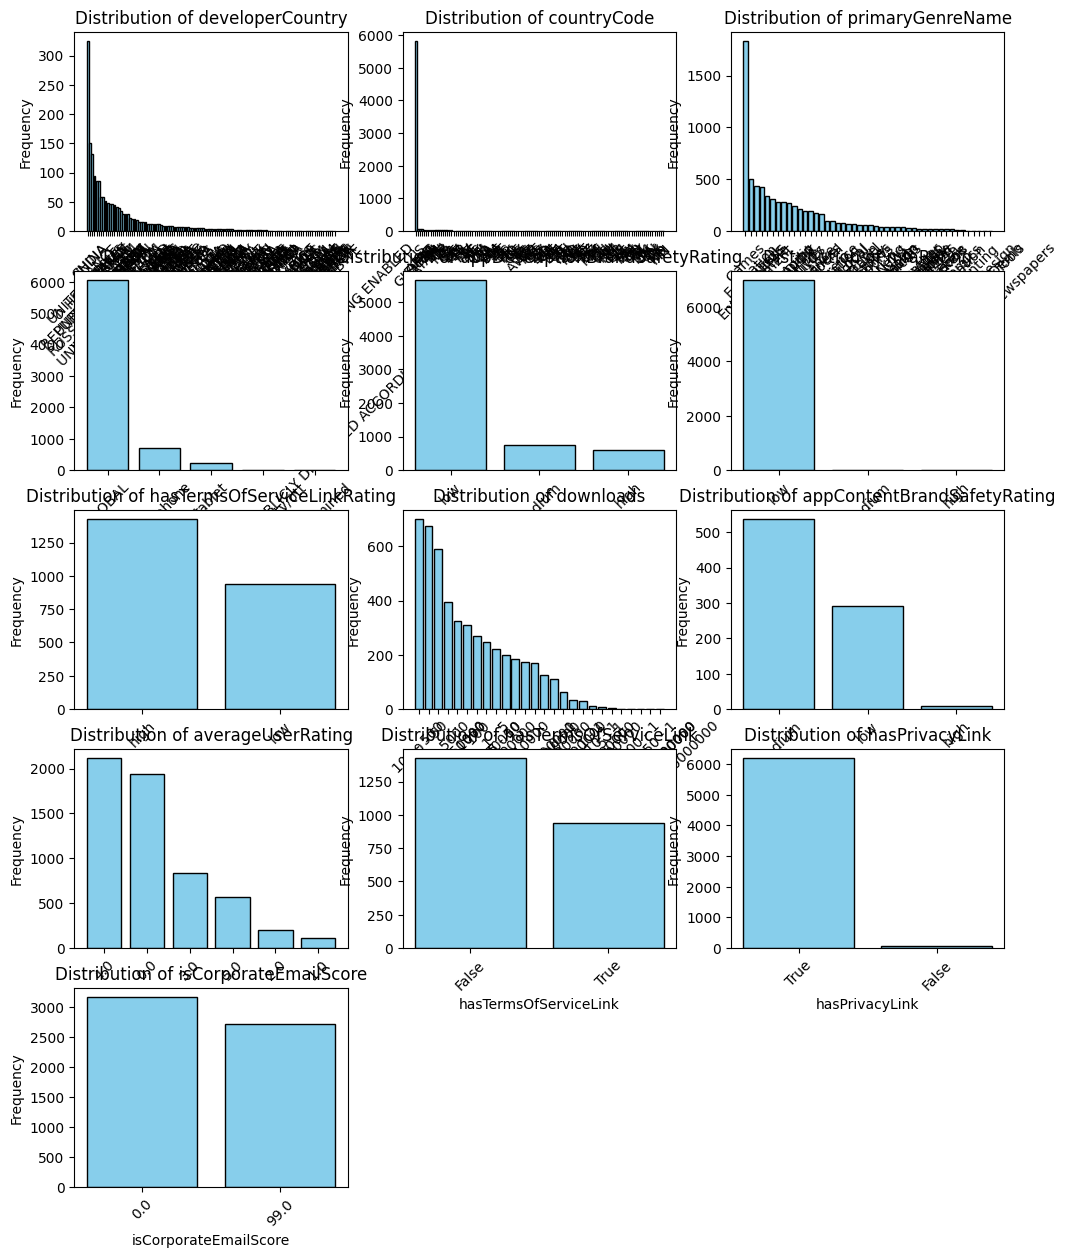

In [83]:
all_cols = list(categorical_cols) + list(boolean_cols)
n_rows = -(-len(all_cols) // 3)  # Ceiling division
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(all_cols):
    value_counts = X[col].value_counts()
    axes[i].bar(value_counts.index.astype(str), value_counts.values, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=45)

# Hapus sisa subplot kosong jika ada
for j in range(len(all_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


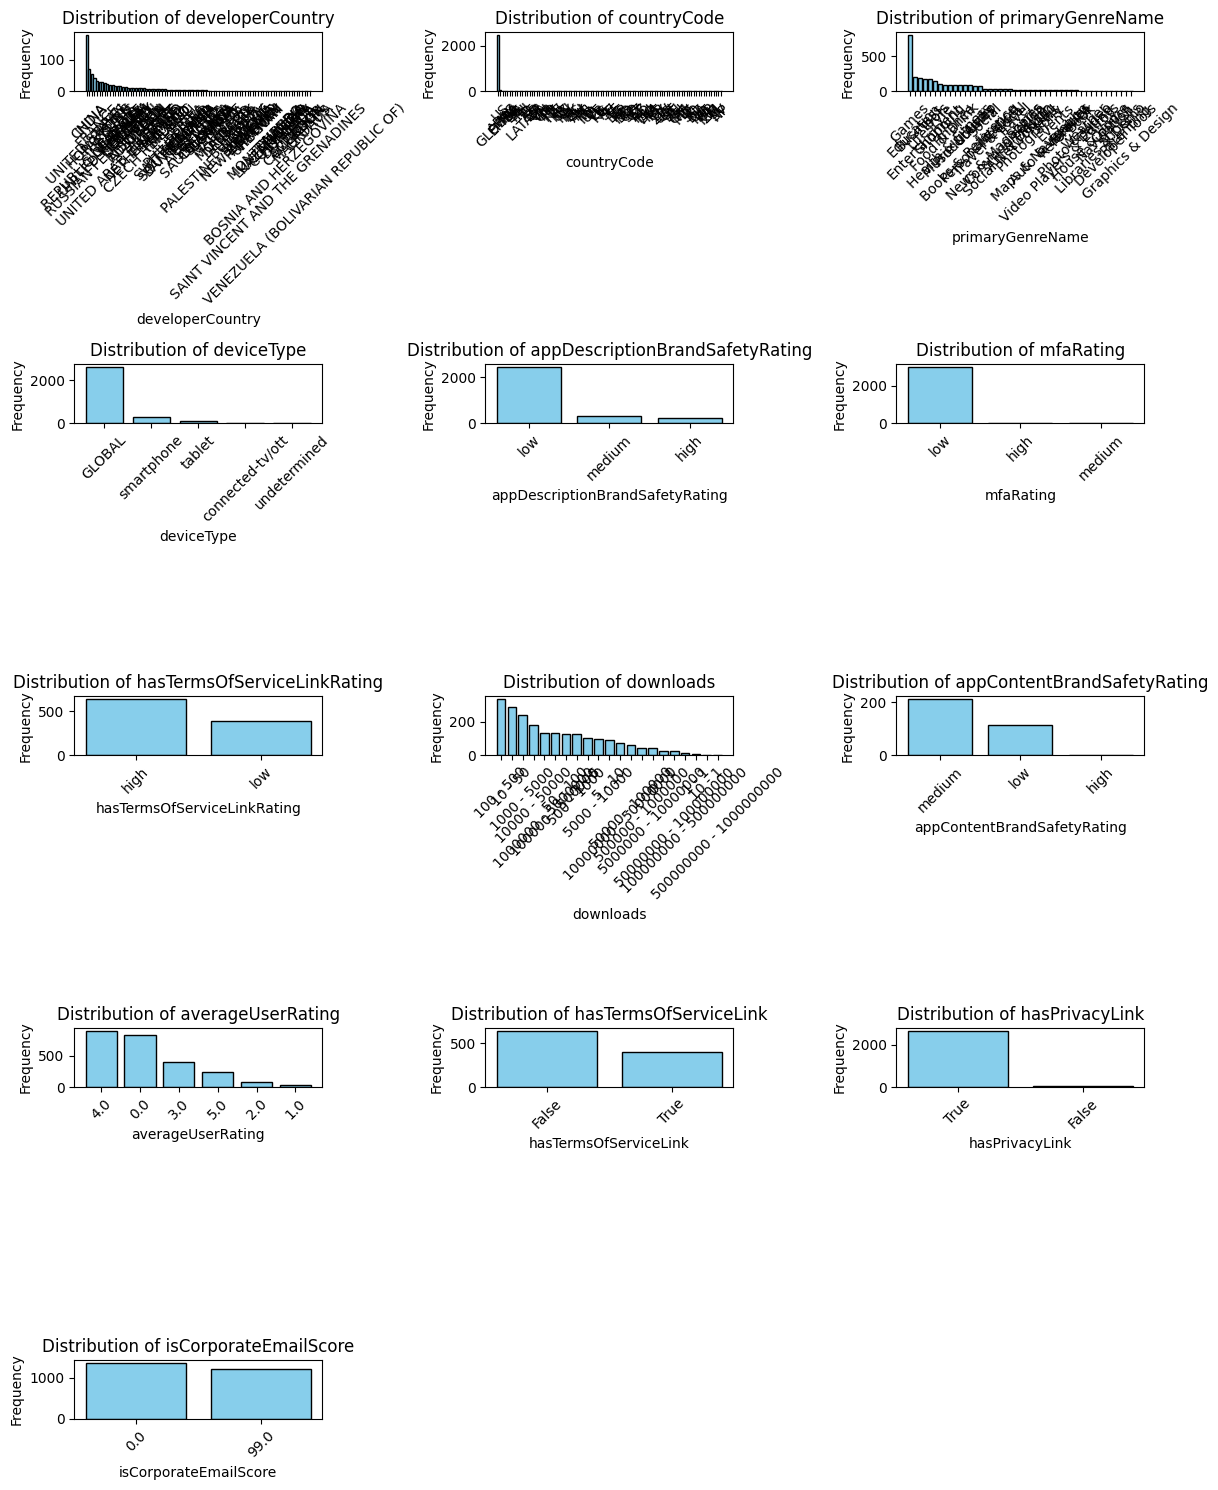

In [84]:
import matplotlib.pyplot as plt

all_cols = list(categorical_cols) + list(boolean_cols)
n_rows = -(-len(all_cols) // 3)  # Ceiling division
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(all_cols):
    value_counts = test[col].value_counts()
    axes[i].bar(value_counts.index.astype(str), value_counts.values, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=45)

# Hapus sisa subplot kosong jika ada
for j in range(len(all_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


<h2>Histogram For Numerical Column</h2>

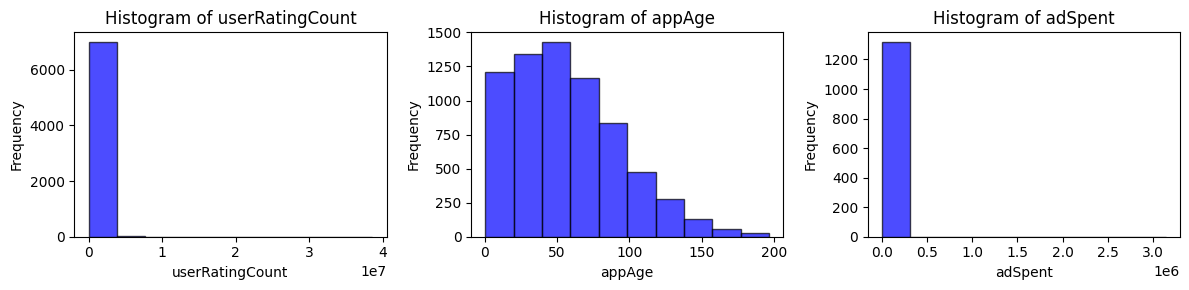

In [85]:
# Plot histogram untuk setiap kolom numerik
n_cols = 3  # Jumlah kolom per baris
n_rows = -(-len(numeric_cols) // 3)  # Hitung jumlah baris (ceil division)

# Buat subplot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))
axes = axes.flatten()  # Flatten menjadi array 1D untuk iterasi
all_plot=[]
# Plot setiap histogram di subplot
for i, col in enumerate(numeric_cols):
    axes[i].hist(X[col], bins=10, color='blue', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    all_plot.append(col)

# Hapus sisa subplot kosong (jika ada)
for i in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[i])

# Optimalkan tata letak
plt.tight_layout()
plt.show()

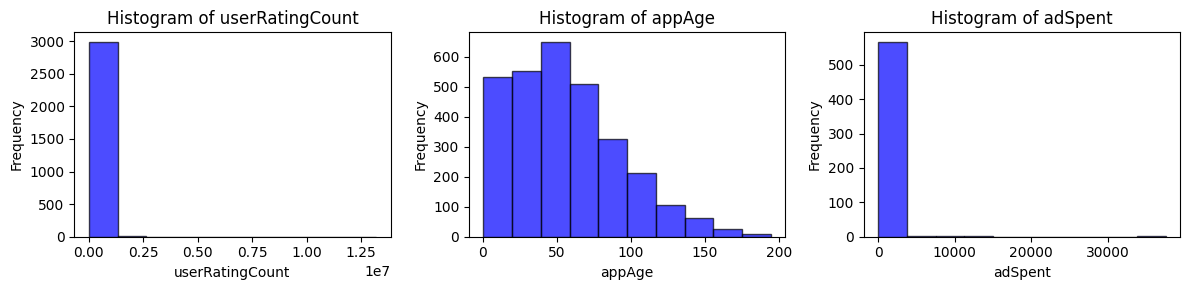

In [86]:
# Plot histogram untuk setiap kolom numerik
n_cols = 3  # Jumlah kolom per baris
n_rows = -(-len(numeric_cols) // 3)  # Hitung jumlah baris (ceil division)

# Buat subplot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))
axes = axes.flatten()  # Flatten menjadi array 1D untuk iterasi
all_plot=[]
# Plot setiap histogram di subplot
for i, col in enumerate(numeric_cols):
    axes[i].hist(test[col], bins=10, color='blue', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    all_plot.append(col)

# Hapus sisa subplot kosong (jika ada)
for i in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[i])

# Optimalkan tata letak
plt.tight_layout()
plt.show()

<h2>Correlation Analysis</h2>

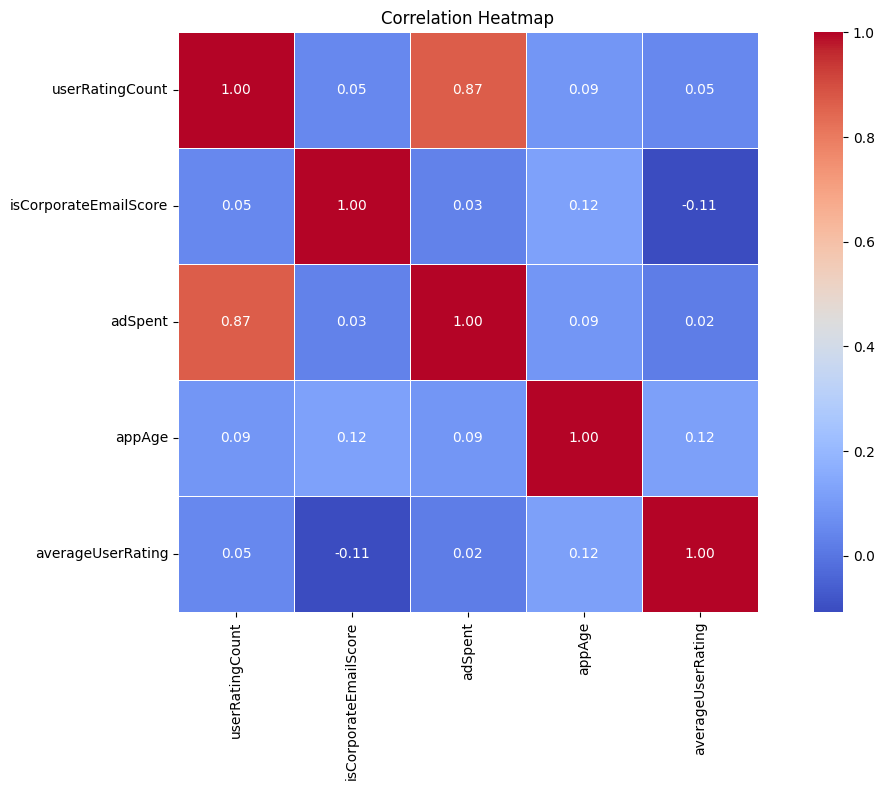

In [87]:
#For Numeric 
import seaborn as sns
corr_matrix = X.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

<h3>For Categorical Column</h3>

In [88]:
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

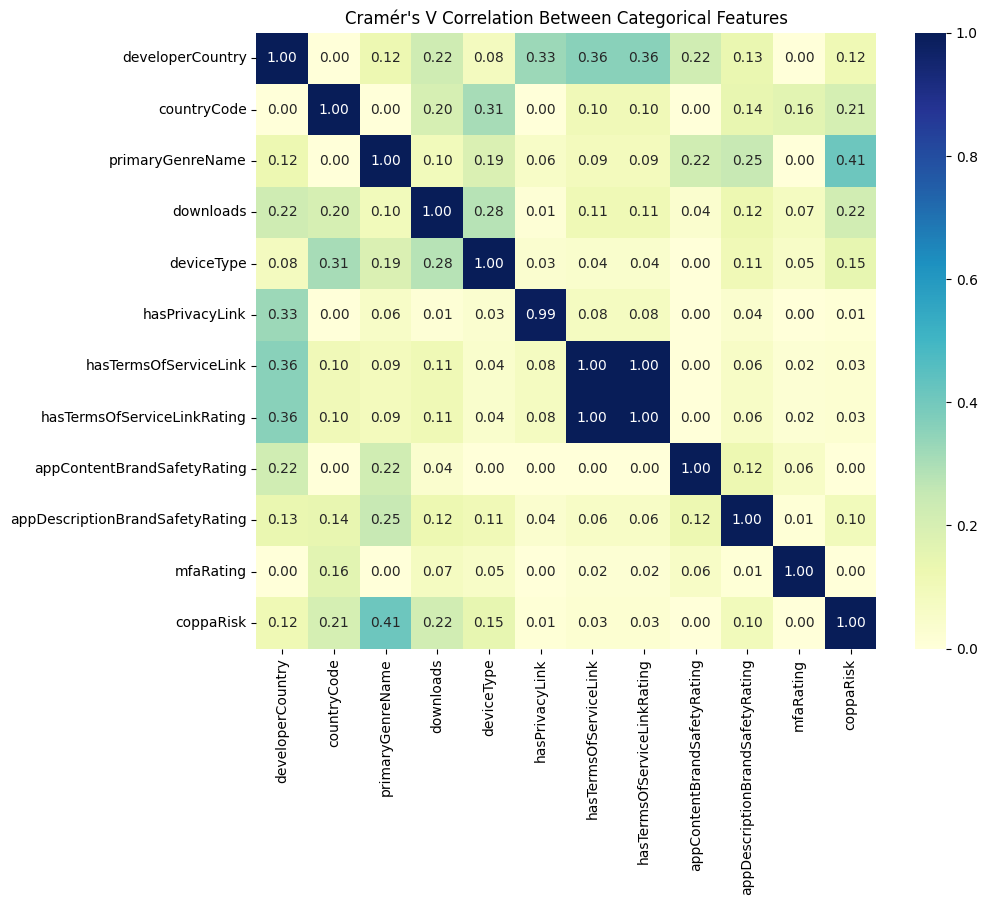

In [89]:
x_cor=X.copy()
x_cor['coppaRisk']=y
categorical_cols = x_cor.select_dtypes(include=['object','bool']).columns
cramer_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        cramer_matrix.loc[col1, col2] = cramers_v(x_cor[col1], x_cor[col2])
cramer_matrix = cramer_matrix.astype(float)
plt.figure(figsize=(10, 8))
sns.heatmap(cramer_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Cramér's V Correlation Between Categorical Features")
plt.show()

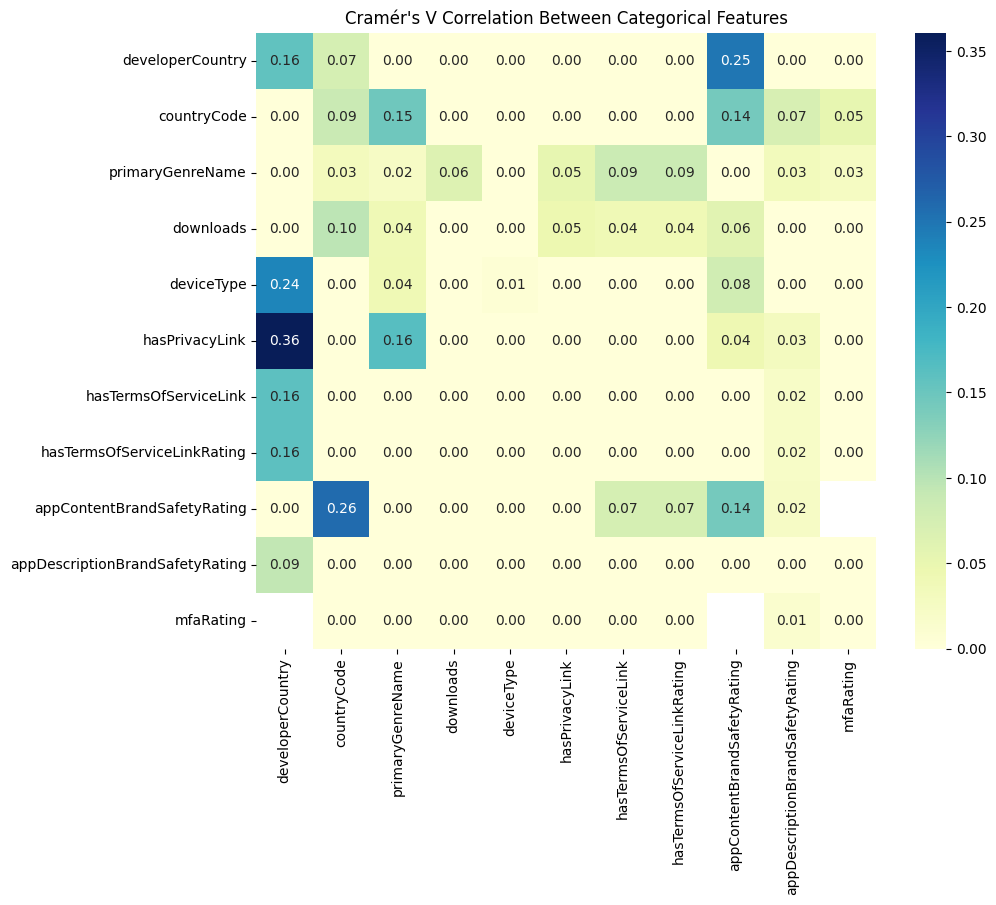

In [90]:
categorical_cols = X.select_dtypes(include=['object','bool']).columns
cramer_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        cramer_matrix.loc[col1, col2] = cramers_v(test[col1], x_cor[col2])
cramer_matrix = cramer_matrix.astype(float)
plt.figure(figsize=(10, 8))
sns.heatmap(cramer_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Cramér's V Correlation Between Categorical Features")
plt.show()

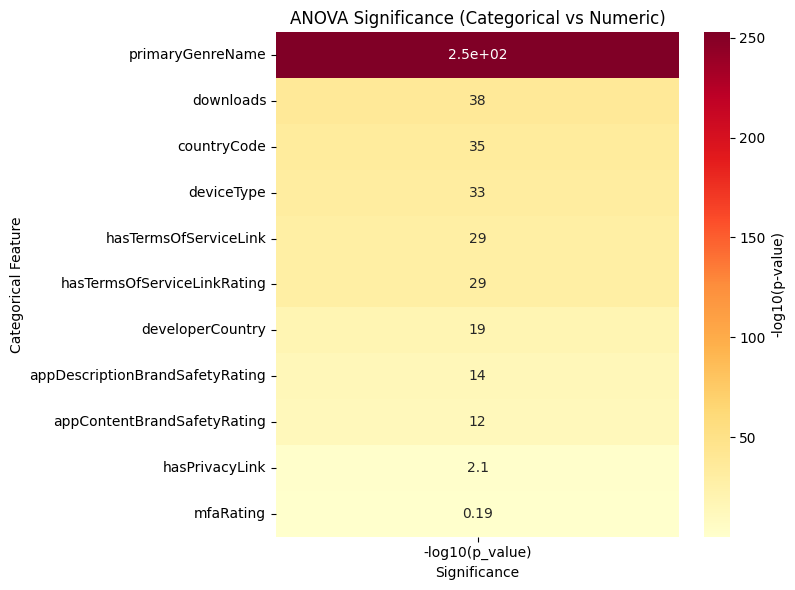

In [91]:
from scipy.stats import f_oneway
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

def anova_categorical_vs_numeric(df, numeric_col_name, do_encoding=True):
    results = {}
    encoders = {}
    categorical_cols = df.select_dtypes(include='object').columns

    df_encoded = df.copy()

    # Konversi target kolom numerik ke float (handle jika string)
    df_encoded[numeric_col_name] = pd.to_numeric(df_encoded[numeric_col_name], errors='coerce')

    for cat_col in categorical_cols:
        try:
            if do_encoding:
                le = LabelEncoder()
                df_encoded[cat_col] = le.fit_transform(df[cat_col].astype(str))
                encoders[cat_col] = le

            groups = [group[numeric_col_name].dropna() for _, group in df_encoded.groupby(cat_col)]
            if len(groups) > 1:
                f_stat, p_val = f_oneway(*groups)
                results[cat_col] = p_val
        except Exception as e:
            print(f"Could not process {cat_col}: {e}")

    result_df = pd.DataFrame.from_dict(results, orient='index', columns=['p_value']).sort_values('p_value')
    result_df['-log10(p_value)'] = -result_df['p_value'].apply(lambda p: np.log10(p) if p > 0 else 0)

    return result_df, df_encoded, encoders
anova_results, encoded_X, label_encoders = anova_categorical_vs_numeric(x_cor, 'coppaRisk')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(anova_results[['-log10(p_value)']], annot=True, cmap="YlOrRd", cbar_kws={'label': '-log10(p-value)'})
plt.title("ANOVA Significance (Categorical vs Numeric)")
plt.ylabel("Categorical Feature")
plt.xlabel("Significance")
plt.tight_layout()
plt.show()

<h3><strong>Drop feature redundant between hasTermsOfServiceLink and hasTermsOfServiceLinkRating</strong></h3>
<ul>
    <li>Harus drop karena feature redundant dan bernilai sama misal true pada satu kolom maka kolom sebelah false</li>
    <li>Buatlah fitur dari value 100% menjadi fitur baru seperti primaryGenreName atau countryCode</li>
</ul>

## Feature Engineering

<h1>🧠 Feature Engineering: COPPA Risk Based on App Genre</h1>

<ul>
  <li><strong>1. Definisi Kategori Risiko Genre</strong>
    <ul>
      <li><code>high_coppa_risk_genres</code>: Genre dengan risiko tinggi terkait anak-anak (misalnya <em>Games</em>, <em>Education</em>).</li>
      <li><code>medium_coppa_risk_genres</code>: Genre dengan risiko menengah (misalnya <em>Music</em>, <em>Social Networking</em>).</li>
      <li><code>low_coppa_risk_genres</code>: Genre yang umumnya tidak menarik untuk anak-anak (misalnya <em>Finance</em>, <em>Medical</em>).</li>
    </ul>
  </li>
  
  <li><strong>2. Fungsi <code>genre_risk_score()</code></strong>
    <ul>
      <li>Mengembalikan skor numerik berdasarkan tingkat risiko:
        <ul>
          <li><code>0</code>: Risiko tinggi</li>
          <li><code>1</code>: Risiko menengah</li>
          <li><code>2</code>: Risiko rendah</li>
        </ul>
      </li>
      <li>Untuk genre yang tidak tercakup, default-nya adalah <code>1</code>.</li>
    </ul>
  </li>
  
  <li><strong>3. Menambahkan Fitur <code>genre_risk_score</code></strong>
    <ul>
      <li>Diterapkan ke dataset <code>X</code> dan <code>test</code>.</li>
      <li>Menggunakan kolom <code>primaryGenreName</code> untuk menghasilkan skor risiko numerik.</li>
      <li>Contoh: Genre "Games" → skor 0, "Finance" → skor 2.</li>
    </ul>
  </li>
  
  <li><strong>4. Menambahkan Fitur Boolean <code>is_kids_content</code></strong>
    <ul>
      <li>Fitur ini menandai apakah genre termasuk konten anak-anak secara eksplisit.</li>
      <li>Genre yang termasuk: <code>'Education'</code>, <code>'Games'</code>, <code>'Entertainment'</code>, <code>'Parenting'</code>.</li>
      <li>Hasil berupa <code>True</code> (1) atau <code>False</code> (0) setelah dikonversi ke <code>bool</code>.</li>
      <li>Diterapkan baik ke dataset <code>X</code> maupun <code>test</code>.</li>
    </ul>
  </li>
  
  <li><strong>5. Tujuan Feature Engineering Ini</strong>
    <ul>
      <li>Memberikan sinyal eksplisit ke model machine learning terkait potensi pelanggaran COPPA.</li>
      <li>Menangkap domain knowledge ke dalam bentuk fitur numerik dan boolean yang mudah diproses model.</li>
      <li>Menambah interpretabilitas dan relevansi prediksi terhadap label <code>coppaRisk</code>.</li>
    </ul>
  </li>
</ul>


In [92]:
categorical_cols = ['developerCountry', 'countryCode', 'primaryGenreName', 'deviceType', 
                    'appDescriptionBrandSafetyRating', 'mfaRating', 'hasTermsOfServiceLinkRating', 
                    'downloads', 'appContentBrandSafetyRating', 'averageUserRating']
boolean_cols = ['hasPrivacyLink', 'isCorporateEmailScore']
numeric_cols = ['userRatingCount', 'appAge', 'adSpent']

In [93]:
# Global imputers dan encoder
xgb_imputer = IterativeImputer(
    estimator=XGBRegressor(objective='reg:squarederror', verbosity=0),
    max_iter=200,
    random_state=RANDOM_STATE
)

knn_imputer = KNNImputer(n_neighbors=75)
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

def feature_imputation(df, is_train=True):
    df = df.copy()
    available_cols = df.columns

    for col in categorical_cols + boolean_cols:
        if col in available_cols:
            mode_val = df[col].mode()[0]
            df[col] = df[col].fillna(mode_val)

    numeric_present = [col for col in numeric_cols if col in available_cols]
    if is_train:
        df[numeric_present] = knn_imputer.fit_transform(df[numeric_present])
    else:
        df[numeric_present] = knn_imputer.transform(df[numeric_present])

    return df

def feature_engineering(df):
    df = df.copy()
    # Genre groups
    high_coppa_risk_genres = [
        'Education', 'Games', 'Entertainment', 'Books & Reference', 'Comics', 
        'Art & Design', 'Parenting', 'Stickers', 'Photo & Video', 'Photography'
    ]
    medium_coppa_risk_genres = [
        'Music', 'Music & Audio', 'Video Players & Editors', 'Social', 
        'Social Networking', 'Communication', 'Personalization'
    ]
    low_coppa_risk_genres = [
        'Finance', 'Business', 'Medical', 'Dating', 'Auto & Vehicles',
        'Developer Tools', 'Travel', 'Travel & Local', 'News', 'News & Magazines'
    ]

    # Genre risk score
    def genre_risk_score(genre):
        if genre in high_coppa_risk_genres:
            return 0
        elif genre in medium_coppa_risk_genres:
            return 1
        elif genre in low_coppa_risk_genres:
            return 2
        else:
            return 1  # Default if not categorized

    df['genre_risk_score'] = df['primaryGenreName'].apply(genre_risk_score)

    df['is_kids_content'] = df['primaryGenreName'].apply(
        lambda x: 1 if x in ['Education', 'Games', 'Entertainment', 'Parenting'] else 0
    ).astype(bool)
    
    if 'genre_risk_score' not in categorical_cols:
        categorical_cols.append('genre_risk_score')
    if 'is_kids_content' not in boolean_cols:
        boolean_cols.append('is_kids_content')

    return df

def feature_encoding(df, is_train=True):
    df = df.copy()
    available_cols = df.columns.tolist()
    encoded_cols = [col for col in (categorical_cols + boolean_cols) if col in available_cols]
    
    if is_train:
        df[encoded_cols] = encoder.fit_transform(df[encoded_cols])
    else:
        df[encoded_cols] = encoder.transform(df[encoded_cols])

    df[encoded_cols] = df[encoded_cols].astype(int)
    return df


def feature_dropping(df):
    df = df.copy()
    drop_cols = ['hasTermsOfServiceLink']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    return df



In [94]:
pipelined_train = feature_dropping(feature_encoding(feature_engineering(feature_imputation(train))))

X, y = pipelined_train, target[LABEL]
X.head()

,developerCountry,countryCode,userRatingCount,primaryGenreName,downloads,deviceType,hasPrivacyLink,hasTermsOfServiceLinkRating,isCorporateEmailScore,adSpent,appAge,averageUserRating,appContentBrandSafetyRating,appDescriptionBrandSafetyRating,mfaRating,genre_risk_score,is_kids_content
0,76,92,127731.0,38,5,2,1,1,1,14.017220,160.400000,4,2,1,1,1,0
1,0,40,0.0,23,17,0,1,0,1,32.640422,17.500000,0,2,1,1,2,0
2,105,25,51143.0,15,24,0,1,1,0,31.883163,30.766667,4,2,1,1,0,1
3,37,40,1074.0,15,5,0,1,0,1,183.287874,71.533333,4,2,1,1,0,1
4,20,40,17.0,40,6,0,1,0,1,36.261624,52.400000,4,2,1,1,1,0


# Model Evaluation

<h1>🧮 Model Selection and Tuning Strategy</h1>

<ul>
  <li><strong>1. Pemilihan Model</strong>
    <ul>
      <li>Model yang digunakan terdiri dari <code>CatBoost</code>, <code>XGBoost</code>, <code>GradientBoosting</code>, <code>LightGBM</code>, <code>HistGradientBoosting</code>, dan <code>Random Forest</code>.</li>
      <li>Seluruh model kecuali <code>Random Forest</code> merupakan model <em>boosting</em>, yang umumnya sangat kuat dalam menangkap pola kompleks dan interaksi fitur.</li>
    </ul>
  </li>
  
  <li><strong>2. Strategi Hyperparameter Tuning</strong>
    <ul>
      <li>Model boosting di-tuning menggunakan <strong>Optuna</strong> dengan objective untuk memaksimalkan <code>AUC</code>.</li>
      <li>Parameter akhir yang digunakan merupakan hasil dari pencarian hyperparameter terbaik pada data validasi.</li>
    </ul>
  </li>
  
  <li><strong>3. Alasan Memasukkan Random Forest</strong>
    <ul>
      <li><code>Random Forest</code> digunakan sebagai baseline sekaligus <em>penyeimbang</em> karena bersifat <em>bagging</em> (bukan boosting).</li>
      <li>Dengan pendekatan ensembel yang beragam, Random Forest membantu mengurangi korelasi antar model yang terlalu mirip.</li>
      <li>Parameter yang digunakan untuk Random Forest adalah <strong>default</strong> agar tidak mendominasi dan tetap menjaga karakter kontras dengan model boosting.</li>
    </ul>
  </li>
</ul>


In [95]:
# Inisialisasi class weights
classes = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)


In [96]:
cb ={
    'iterations': 353, 
    'depth': 10, 
    'learning_rate': 0.01338350278353313, 
    'l2_leaf_reg': 4.944651430612399, 
    'random_strength': 0.45913360376898027, 
    'border_count': 98, 
    'bagging_temperature': 0.809289411643156,
    'class_weights':  class_weights,
    'cat_features': categorical_cols + boolean_cols,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'verbose': 0,
    'random_state': RANDOM_STATE
}

xgb={
    'enable_categorical': True,
    'n_estimators': 481, 
    'max_depth': 3, 
    'learning_rate': 0.01662047470284555, 
    'subsample': 0.9403446095594594, 
    'colsample_bytree': 0.9168264598954045, 
    'gamma': 2.307397271213472, 
    'reg_alpha': 0.08781243735036227, 
    'reg_lambda': 1.4480552600655057,
    'scale_pos_weight': 6.850568965886105,
    'random_state':RANDOM_STATE
}

gb={
    'n_estimators': 257, 
    'learning_rate': 0.020356511002051117, 
    'max_depth': 3, 
    'min_samples_split': 10, 
    'min_samples_leaf': 10, 
    'subsample': 0.9604774942977159,
    'random_state':RANDOM_STATE
}

lgbm={
    'n_estimators': 355, 
    'learning_rate': 0.012860450938355758, 
    'num_leaves': 54, 
    'max_depth': 3, 
    'min_child_samples': 65, 
    'subsample': 0.5689928572101675, 
    'colsample_bytree': 0.9547860370069182, 
    'reg_alpha': 0.0021982142562961627, 
    'reg_lambda': 0.017112362057482036,
    'scale_pos_weight': 8.311734357305085,
    'random_state':RANDOM_STATE, 
    'verbosity':-1
}

hgb={
    'learning_rate': 0.008057773917777088, 
    'max_iter': 190, 
    'max_depth': 8, 
    'min_samples_leaf': 42, 
    'l2_regularization': 2.956049934102851, 
    'max_bins': 61,
    'random_state':RANDOM_STATE
}

rf={
    'random_state': RANDOM_STATE
}


In [97]:
# Asumsikan kamu sudah punya `best_params` untuk CatBoost
models = [
    ('catboost', CatBoostClassifier(**cb)),
    ('hgb', HistGradientBoostingClassifier(**hgb)),
    ('xgb', XGBClassifier(**xgb)),
    ('lgbm', LGBMClassifier(**lgbm)),
    ('gb', GradientBoostingClassifier(**gb)),
    ('rf', RandomForestClassifier(**rf)),
]

In [98]:
def hill_climbing_ensemble(models, X_train, y_train, X_test, y_test, max_models=None, verbose=True):
    val_preds = []
    for name, model in models:
        print(f"Training model: {name}")
        model.fit(X_train, y_train)
        pred = model.predict_proba(X_test)[:, 1]
        val_preds.append((name, model, pred))
            
    candidates = val_preds.copy()
    ensemble_preds = []
    selected_models = []
    ensemble_scores = []

    for i in range(max_models or len(models)):
        best_score = -np.inf
        best_candidate = None

        for candidate in candidates:
            _, _, pred = candidate
            temp_preds = [p for _, _, p in ensemble_preds] + [pred]
            avg_pred = np.mean(temp_preds, axis=0)
            score = roc_auc_score(y_test, avg_pred)

            if score > best_score:
                best_score = score
                best_candidate = candidate

        if best_candidate is not None:
            ensemble_preds.append(best_candidate)
            selected_models.append((best_candidate[0], best_candidate[1]))
            candidates.remove(best_candidate)
            ensemble_scores.append(best_score)

            if verbose:
                print(f"Iteration {i+1}: Added {best_candidate[0]} -> ROC AUC = {best_score:.5f}")
        else:
            break

    final_pred = np.mean([p for _, _, p in ensemble_preds], axis=0)
    return final_pred, selected_models, ensemble_scores


In [99]:
# 🔧 Panggil Hill Climbing Ensemble
ensemble_pred, selected_models, ensemble_scores = hill_climbing_ensemble(
    models=models,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    max_models=None
)

# 🎯 Evaluasi akhir
final_auc = roc_auc_score(y_test, ensemble_pred)
print(f"\nFinal Hill Climbing Ensemble ROC AUC: {final_auc:.5f}")

# 🧩 Model-model terpilih dalam ensemble
print("\nSelected models in the ensemble:")
for i, (name, _) in enumerate(selected_models):
    print(f"{i+1}. {name}")

Training model: catboost
Training model: hgb
Training model: xgb
Training model: lgbm
Training model: gb
Training model: rf
Iteration 1: Added hgb -> ROC AUC = 0.90577
Iteration 2: Added catboost -> ROC AUC = 0.90764
Iteration 3: Added rf -> ROC AUC = 0.91091
Iteration 4: Added xgb -> ROC AUC = 0.91111
Iteration 5: Added gb -> ROC AUC = 0.91053
Iteration 6: Added lgbm -> ROC AUC = 0.90962

Final Hill Climbing Ensemble ROC AUC: 0.90962

Selected models in the ensemble:
1. hgb
2. catboost
3. rf
4. xgb
5. gb
6. lgbm


# Prepare Test Dataset

In [100]:
test = feature_dropping(feature_encoding(feature_engineering(feature_imputation(test))))
test

,developerCountry,countryCode,userRatingCount,primaryGenreName,downloads,deviceType,hasPrivacyLink,hasTermsOfServiceLinkRating,isCorporateEmailScore,adSpent,appAge,averageUserRating,appContentBrandSafetyRating,appDescriptionBrandSafetyRating,mfaRating,genre_risk_score,is_kids_content
0,81,30,2.0,22,5,0,1,0,0,20.889686,81.600000,5,2,1,1,2,0
1,29,24,0.0,15,15,0,1,1,0,0.027742,24.700000,0,2,1,1,0,1
2,81,70,13059.0,15,5,2,1,0,1,9.249056,40.300000,4,2,1,1,0,1
3,81,30,0.0,15,5,0,1,0,0,25.089037,39.233333,0,2,2,1,0,1
4,81,30,0.0,34,5,0,1,0,0,21.955476,65.533333,0,2,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,81,30,0.0,32,5,0,1,1,0,28.880527,94.100000,0,2,1,1,1,0
2996,81,30,10.0,5,5,0,1,0,1,24.395862,25.033333,5,2,1,1,2,0
2997,81,30,2.0,13,5,0,1,0,0,20.889686,76.000000,2,2,1,1,2,0
2998,81,30,0.0,5,2,0,1,0,1,28.880527,100.633333,0,2,1,1,2,0


In [101]:
test_preds = []
a=[]
for name, model in selected_models:
    pred_proba = model.predict_proba(test)[:, 1]
    a.append(pred_proba)

test_pred = np.mean(a, axis=0)

In [102]:
submission = submission_sample.copy()
submission['coppaRisk'] = test_pred
submission.to_csv('submission.csv', index=False)